In [92]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [93]:
from scripts.get_top_stocks import *
top_stocks_long, top_stocks_long_short = generate_top_stocks_df()
common_top_stocks = get_common_top_stocks(top_stocks_long, top_stocks_long_short)

# specify variables for dataset generation
start_date = '2023-01-01'
end_date = '2024-08-01'
interval = "1h"
trading_days_per_year = 252
hours_per_day = 6.5


Results saved to 'top_30_stocks_long_only.csv' and 'top_30_stocks_long_short.csv'

Detailed metrics for top stock (Long-Only Strategy) SMCI:
Final Close Price: 284.26
60-day Return: 250.61%
Average Hourly Volatility: 0.6678
Average Sharpe Ratio: 1.6242
Average Hourly Volume: 355714

num common_top_stocks:  35


In [94]:
from scripts.generate_dataset_features import *


df = get_all_stock_features_df(
    stocks_list=common_top_stocks,
    start_date=start_date,
    end_date=end_date,
    interval=interval,
    trading_days_per_year=trading_days_per_year, 
    hours_per_day=hours_per_day)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [95]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns,Log_Return_shift,stock_name,Stock_Position,Target,ticker
0,2023-02-24 13:30:00-05:00,169.729996,170.188599,169.139999,170.070007,170.070007,1750690,0.001707,-0.001688,0.116291,...,4.888908,1.510907,-1.967638,-5.354547,-1.09,-0.001000,META,hold,2,META
1,2023-02-24 14:30:00-05:00,170.089996,170.720001,169.610001,169.899994,169.899994,2058333,-0.001000,0.051902,0.080767,...,3.421159,1.422552,-1.854190,-5.170984,-1.09,0.003056,META,hold,2,META
2,2023-02-24 15:30:00-05:00,169.910004,170.490005,169.600006,170.419998,170.419998,2002423,0.003056,0.007657,-0.013768,...,-5.473431,4.507666,-2.691358,-6.412185,-1.09,0.006201,META,buy,3,META
3,2023-02-27 09:30:00-05:00,171.875000,173.119995,170.509995,171.479996,171.479996,4485623,0.006201,0.227990,0.382735,...,-0.901236,-1.610476,-20.280946,-11.763411,0.31,-0.008903,META,sell,1,META
4,2023-02-27 10:30:00-05:00,171.460007,171.630005,169.690002,169.960007,169.960007,2431726,-0.008903,-0.143383,-0.296920,...,1.963164,1.597071,-1.988151,-5.531112,0.31,-0.002356,META,hold,2,META


In [96]:
# additional logic to ensure buy remains +ve and sell remainvs -ve

print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'buy')]))
print(len(df[(df.Log_Return_shift < 0) & (df.Stock_Position == 'strong buy')]))

print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'sell')]))
print(len(df[(df.Log_Return_shift > 0) & (df.Stock_Position == 'strong sell')]))

# all good

0
0
0
0


In [107]:
# df["Log_Return_shift"] = df["Log_Return"].shift(-1)
df['Target'] = df['Target'].map({1:0, 2:1, 3:2})
df=df.dropna()

In [108]:
# df_meta = df[df['stock_name'] == 'META']

target = 'Target'
features = df.columns[8:-1]
features = features.drop('stock_name')
features = features.drop('Stock_Position')

In [109]:
# sort df according to date
# df1 = df.sort_values("Datetime").reset_index(drop=True)
df1 = df.sort_values("Datetime").reset_index(drop=True)
# train test split on index
train_size, val_size, test_size = 0.8, 0.1, 0.1
train_size, val_size, test_size = int(len(df1) * train_size), int(len(df1) * val_size), int(len(df1) * test_size)
train_df = df1.iloc[:train_size]
val_df = df1.iloc[train_size:train_size + val_size]
test_df = df1.iloc[train_size + val_size:]

train_df.shape,val_df.shape,test_df.shape

((71869, 85), (8983, 85), (8985, 85))

In [110]:
features

Index(['EMAVolumeDiff2', 'SMAVolumeDiff2', 'EMACloseDiff2', 'SMACloseDiff2',
       'VWAP2', 'VolatilityStdDev2', 'Volatility2', 'Momentum2',
       'EMAVolumeDiff4', 'SMAVolumeDiff4', 'EMACloseDiff4', 'SMACloseDiff4',
       'VWAP4', 'VolatilityStdDev4', 'Volatility4', 'Momentum4',
       'EMAVolumeDiff8', 'SMAVolumeDiff8', 'EMACloseDiff8', 'SMACloseDiff8',
       'VWAP8', 'VolatilityStdDev8', 'Volatility8', 'Momentum8',
       'EMAVolumeDiff16', 'SMAVolumeDiff16', 'EMACloseDiff16',
       'SMACloseDiff16', 'VWAP16', 'VolatilityStdDev16', 'Volatility16',
       'Momentum16', 'EMAVolumeDiff32', 'SMAVolumeDiff32', 'EMACloseDiff32',
       'SMACloseDiff32', 'VWAP32', 'VolatilityStdDev32', 'Volatility32',
       'Momentum32', 'EMAVolumeDiff64', 'SMAVolumeDiff64', 'EMACloseDiff64',
       'SMACloseDiff64', 'VWAP64', 'VolatilityStdDev64', 'Volatility64',
       'Momentum64', 'EMAVolumeDiff128', 'SMAVolumeDiff128', 'EMACloseDiff128',
       'SMACloseDiff128', 'VWAP128', 'VolatilityStdDev128'

In [111]:
features_numpy = df[features].to_numpy()
target_numpy = df[target].to_numpy()
features = features.drop('Target')
X_train = train_df[features].to_numpy()
y_train = train_df[target].to_numpy()
print(X_train.shape,y_train.shape)

X_val = val_df[features].to_numpy()
y_val = val_df[target].to_numpy()
print(X_val.shape,y_val.shape)

X_test = test_df[features].to_numpy()
y_test = test_df[target].to_numpy()
print(X_test.shape,y_test.shape)

(71869, 73) (71869,)
(8983, 73) (8983,)
(8985, 73) (8985,)


In [112]:
from scripts.train_predict import *

# standardise the values

scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((71869, 73), (71869,), (8983, 73), (8983,), (8985, 73), (8985,))

In [113]:
X_train

array([[ 1.61782398e-01,  1.56402618e-01, -3.76690598e-01, ...,
        -6.86571239e-03,  5.45547595e-02,  4.39075664e-01],
       [-5.74251953e-01, -7.23433983e-01,  2.37478195e-01, ...,
         1.36224152e-01,  5.45547595e-02,  1.28148933e-01],
       [-1.36270600e+00, -1.27208115e+00, -5.90269084e-01, ...,
        -1.00951858e-02,  5.45547595e-02,  1.47667378e-01],
       ...,
       [ 1.25165613e+00,  1.06784501e+00, -9.48858553e-02, ...,
        -5.54395569e-02, -3.67904643e-01, -2.84272346e+00],
       [ 4.36988211e-01,  2.19572147e-01, -1.98176387e-01, ...,
        -1.24676122e-01, -3.67904643e-01, -1.02914132e+00],
       [-2.32850789e-01, -8.75252992e-01, -3.02741505e-01, ...,
        -1.51204797e-03, -3.67904643e-01,  4.19486937e-01]])

In [119]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm
from alive_progress import alive_it

def train():
    # initialise training params
    best_score = float('inf')
    best_params = None
    best_model = None
    

    # Define the parameter grid
    # param_grid={"learning_rate": (0.05, 0.10, 0.15),
    #             "max_depth": [ 3, 4, 6, 8],
    #             "min_samples_leaf": [0.001, 0.05, 0.1],
    #             "n_estimators": [100, 200, 500]
    #             },
    param_grid = {
        'eta': [0.1, 0.3, 0.5],
        'gamma': [0, ],
        'max_depth': [6, 8],
    }
    # best_model = xgb.XGBClassifier()
    # best_model.fit(X_train, y_train)
    # y_pred = best_model.predict(X_val)
    # best_score = accuracy_score(y_val, y_pred)
    # best_params = 0
    for params in alive_it(ParameterGrid(param_grid)):
        model = xgb.XGBClassifier(**params) # initialise new model before each run
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        
        if score < best_score:
            best_score = score
            best_params = params
            best_model = model
            print(f"score: {round(best_score,7)}")
            # print(f"score: {round(best_score,7)}, params: {best_params}")

    print(f"Best parameters found: {best_params}")
    print(f"Best validation score: {round(best_score,5)}")

    return best_model, best_params, best_score, X_test, y_test

def predict(best_model,X_test, y_test):
    y_pred = best_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy score: {round(score,5)}")
    
    return y_pred

def train_predict():
    best_model, best_params, best_score, X_test, y_test = train()
    y_pred = predict(best_model, X_test, y_test)
    acc = accuracy_score(y_test, y_pred)
 
    
    return best_model, best_params, best_score, acc, y_pred
    

In [120]:
best_model, best_params, best_score, acc, y_pred = train_predict()

on 0: score: 0.9632639
on 2: score: 0.9620394
|████████████████████████████████████████| 6/6 [100%] in 17.2s (0.35/s) 
Best parameters found: {'eta': 0.3, 'gamma': 0, 'max_depth': 6}
Best validation score: 0.96204
Test set accuracy score: 0.95893


In [131]:
unique, counts = np.unique(y_pred, return_counts=True)

dict(zip(unique, counts))

{0: 1969, 1: 5218, 2: 1798}

In [132]:
unique, counts = np.unique(y_test, return_counts=True)

dict(zip(unique, counts))

{0: 1937, 1: 5347, 2: 1701}

accuracy: 95.89


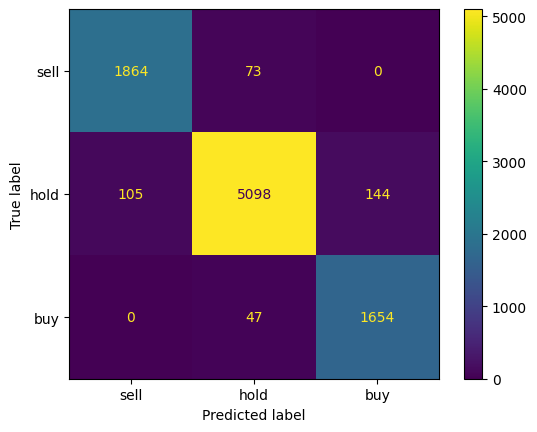

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(f"accuracy: {round(acc*100,2)}")
labels = ['sell', 'hold', 'buy']
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.show()

In [124]:
for ticker in test_df.stock_name.unique():
    stock_df = test_df[test_df['stock_name']==ticker]
    stock_X_test = stock_df[features].to_numpy()
    stock_y_test = stock_df[target].to_numpy()
    stock_preds = best_model.predict(stock_X_test)
    acc = accuracy_score(stock_y_test, stock_preds)

    print(f"{ticker}: {round(acc*100, 2)}")

ZS: 61.85
DASH: 55.82
TTD: 60.24
MU: 51.41
NVDA: 49.0
CRWD: 57.26
LRCX: 54.03
WDAY: 66.13
MRNA: 57.26
META: 61.69
MELI: 62.5
CPRT: 57.66
BKNG: 66.13
MDB: 57.66
CDNS: 56.05
DDOG: 64.92
INTU: 65.73
INTC: 60.48
AMZN: 58.47
TSLA: 55.24
MRVL: 58.47
AMD: 56.85
TEAM: 70.56
PDD: 63.31
MSFT: 66.53
SMCI: 58.87
PANW: 57.26
SNPS: 58.06
ADBE: 58.47
ABNB: 71.77
AVGO: 44.76
AMAT: 51.21
RR.L: 63.79
III.L: 57.47
MKS.L: 63.51
